<a href="https://colab.research.google.com/github/ML4SCI/ML4SCIHackathon/blob/main/ParticleImagesChallenge/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><h1>ML4SCI Hackathon 2021</h1>
<h2>Problem Statement : </h2>

*   One of the important aspects of searches for new physics at the Large Hadron Collider (LHC) involves the classification of various High-Energy Particles in collision events
*   The goal of this challenge is to implement Vision Transformers on the dataset which will classify electron and photon particles as accurately as possible based on the detector images provided in the dataset.
      *  Dataset:
              https://cernbox.cern.ch/index.php/s/AtBT8y4MiQYFcgc (Photons)
              https://cernbox.cern.ch/index.php/s/FbXw3V4XNyYB3oA (Electrons)
      *  The dataset consists of 32x32 matrices (two channels - hit energy and time) for two classes of particles electrons and photons impinging on a calorimeter. 
*   The preferred metric for evaluating the model is ROC curve (Receiver Operating Characteristic curve) and the AUC (Area Under the ROC Curve) score.

## Vision Tranformers:
The field of Computer Vision has for years been dominated by Convolutional Neural Networks (CNNs) which use filters and create feature used by a multi-layer perceptron to perform the desired classification.
But recently this field has been incredibly revolutionized by the architecture of Vision Transformers (ViT), which through the mechanism of self-attention has proven to obtain excellent results on many tasks.

### How the Vision Transformer works in a nutshell
1. Split an image into patches

2. Flatten the patches

3. Produce lower-dimensional linear embeddings from the flattened patches

4. Add positional embeddings

5. Feed the sequence as an input to a standard transformer encoder

6. Pretrain the model with image labels (fully supervised on a huge dataset)

7. Finetune on the downstream dataset for image classification<br>

### Arcitecture
<img src="https://miro.medium.com/max/3000/1*58xYTXTkcwsu2VwmYczcrg.png" alt="Trulli" >

*    Reference link to understand Vision Transformers: https://arxiv.org/pdf/2010.11929.pdf 
*   The following is an example of keras implementation of ViT, feel free to implement using keras/ pytorch.









1.   Mount the drive and navigate to your working folder 
2.   Download the dataset
     *    https://cernbox.cern.ch/index.php/s/AtBT8y4MiQYFcgc (Photons)
     *     https://cernbox.cern.ch/index.php/s/FbXw3V4XNyYB3oA (Electrons)
3.   It is recommended to use GPU for training and inference if possible.
4.   Install the following dependencies



In [ ]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 4.3 MB/s 


In [ ]:
if doGPU:
    import tensorflow as tf
    from tensorflow.compat.v1.keras.backend import set_session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth=True
    set_session(tf.compat.v1.Session(config=config))

In [ ]:
# import libraries 
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense, Activation 
from tensorflow.keras.layers import Dropout 
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
from tensorflow.keras import metrics

Load the dataset

In [ ]:
import h5py
import numpy as np

filename = "./Electron.hdf5"
data1 = h5py.File(filename, "r")
Y1 = data1["y"]
X1 = data1["X"]
filename = "./Photon.hdf5"
data0 = h5py.File(filename, "r")
Y0 = data0["y"]
X0 = data0["X"]
X_final = np.concatenate((X0[:], X1[:]), axis=0)
Y_final = np.concatenate((Y0[:], Y1[:]), axis=0)

In [ ]:
X_final.shape

(498000, 32, 32, 2)

Prepare the data




In [ ]:
num_classes = 1
input_shape = (32, 32, 1) #Using the Hit-Energy channel only

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    X_final[:, :, :, 0:1],
    Y_final,
    test_size=0.2,
    random_state=42
)
    
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (398400, 32, 32, 1) - y_train shape: (398400,)
x_test shape: (99600, 32, 32, 1) - y_test shape: (99600,)


Configure the hyperparameters

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 20
image_size = 32 # We'll resize input images to this size
patch_size = 4  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 32
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [256,128]  # Size of the dense layers of the final classifier

Normalize the data <br>
<sub><sup>You can additionally augment it (following the commented part)</sup></sub>

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        #layers.Resizing(image_size, image_size),
        #layers.RandomFlip("horizontal"),
        #layers.RandomRotation(factor=0.02),
        #layers.RandomZoom(
         #   height_factor = 0.2, width_factor = 0.2
        #),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

Implement multilayer perceptron (MLP)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

Implement patch creation as a layer

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Display patches for a sample image

Image size: 32 X 32
Patch size: 4 X 4
Patches per image: 64
Elements per patch: 16


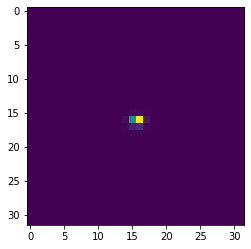

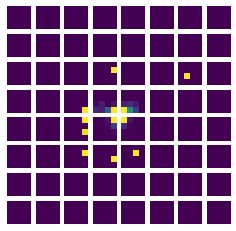

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[0,:,:,0]
plt.imshow(image.astype("float32"))
#plt.axis("off")

patches = Patches(patch_size)(x_train[0:1,:,:,0:1])
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size))
    plt.imshow(patch_img.numpy().astype("float32"))
    plt.axis("off")

Implement the patch encoding layer<br>
<sub>The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.</sub>

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

Build the ViT model<br>
<sub>The ViT model consists of multiple Transformer blocks, which use the layers.MultiHeadAttention layer as a self-attention mechanism applied to the sequence of patches. The Transformer blocks produce a [batch_size, num_patches, projection_dim] tensor, which is processed via an classifier head with softmax to produce the final class probabilities output.

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])
        

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(1)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

Compile, train, and evaluate the mode

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,#keras.optimizers.Adam(lr=0.001),
        loss= keras.losses.BinaryCrossentropy(from_logits=True),#'binary_crossentropy',
        #loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            'accuracy',
            'mae'
        ]
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    #print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/20
2802/2802 [==============================] - 325s 112ms/step - loss: 0.6958 - accuracy: 0.5004 - mae: 0.5232 - val_loss: 0.6931 - val_accuracy: 0.4998 - val_mae: 0.5001
Epoch 2/20
2802/2802 [==============================] - 309s 110ms/step - loss: 0.6503 - accuracy: 0.5796 - mae: 0.6593 - val_loss: 0.5919 - val_accuracy: 0.6876 - val_mae: 0.6600
Epoch 3/20
2802/2802 [==============================] - 311s 111ms/step - loss: 0.5948 - accuracy: 0.6699 - mae: 0.8209 - val_loss: 0.5729 - val_accuracy: 0.6973 - val_mae: 0.9002
Epoch 4/20
2802/2802 [==============================] - 309s 110ms/step - loss: 0.5870 - accuracy: 0.6794 - mae: 0.8478 - val_loss: 0.5688 - val_accuracy: 0.6965 - val_mae: 0.8953
Epoch 5/20
2802/2802 [==============================] - 310s 111ms/step - loss: 0.5829 - accuracy: 0.6835 - mae: 0.8634 - val_loss: 0.5678 - val_accuracy: 0.7002 - val_mae: 0.8198
Epoch 6/20
2802/2802 [==============================] - 309s 110ms/step - loss: 0.5808 - accuracy: 0

Calculate the ROC score 

In [ ]:
from sklearn.metrics import roc_curve, auc
# Evaluate on test set
score = vit_classifier.evaluate(x_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = vit_classifier.predict(x_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

3113/3113 [==============================] - 81s 26ms/step - loss: 0.5727 - accuracy: 0.7120 - mae: 0.7598

Test loss / accuracy: 0.5727 / 0.7120
Test ROC AUC: 0.7777030567826522


ROC Curve Plot 

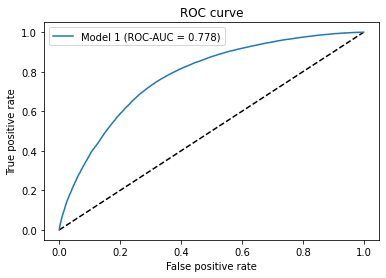

In [ ]:
plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Your turn, All the Best!